In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

#from crossmatch import xmatch
import astropy as apy
from astropy import units as units
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

from astroML.stats import binned_statistic_2d

% matplotlib inline

## Setup data paths

In [2]:
DATA_DIR = "data/"
HLC_FILES = sorted(glob.glob(os.path.join(DATA_DIR, "HLC*.fits")))
NSC_FILES = sorted(glob.glob(os.path.join(DATA_DIR, "stripe82*.txt")))
GAL_FILES = 'data/Galfast-Stripe82.txt'
print("\nRegistered following NSC files: ")
for pth in NSC_FILES:
    print("    "+pth)
print("\nRegistered following HLC files: ")
for pth in HLC_FILES:
    print("    "+pth)
print("\nRegistered following GALFAST files: ")
print("    "+GAL_FILES)


Registered following NSC files: 
    data/stripe82_315_ra_45_-1_3_dec_0.txt
    data/stripe82_315_ra_45_0_dec_1_3.txt

Registered following HLC files: 
    data/HLC.RA_00_to_01.fits
    data/HLC.RA_01_to_02.fits
    data/HLC.RA_02_to_03.fits
    data/HLC.RA_03_to_04.fits
    data/HLC.RA_20_to_21.fits
    data/HLC.RA_21_to_22.fits
    data/HLC.RA_22_to_23.fits
    data/HLC.RA_23_to_24.fits

Registered following GALFAST files: 
    data/Galfast-Stripe82.txt


## Read in the HLC and NSC catalogs to see coverage and completeness

Reading the full catalogs in will likely make the IPy Notebook run out of RAM memory. 

The NSC catalog shows a very uneven distribution of objects acros RA coordinates. While the "spikiness" of the number of objects could be a real effect, the lack of objects from 35-50 degrees of right ascension is indicative of an incomplete dataset.    
The increased number of objects from 300-330 degrees of right ascension is a real effect.

In [7]:
nscdat_part = []
for pth in NSC_FILES:
    nscdat_part.append(Table.read(pth, format="ascii"))
nscdat = apy.table.vstack(nscdat_part)
nsc = Table(nscdat)

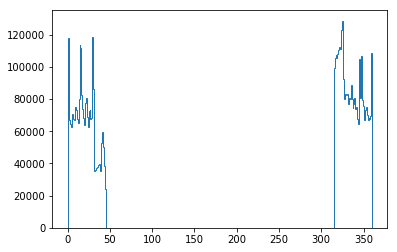

In [16]:
plt.hist(nsc["ra"], histtype="step", bins=360)
plt.xlabel("Ra")
plt.ylabel("Counts")

I do not have required RAM memory to work with the complete HLC dataset as copies are made when slicing and comparison operators are used so columns of interest are unpacked specifically. 
The spike in number of objects with RA=0 exists in the actual catalog and is not a product of faulty read-in procedures or was it caused by mishandled data. These objects make crossmatching very difficult and therefore are cut ot of the working dataset. 

In [22]:
hlcdat_part = []
for pth in HLC_FILES:
    fitsfile = fits.open(pth)
    tmptable = Table(fitsfile[1].data)
    hlcdat_part.append(tmptable)
hlcraw = apy.table.vstack(hlcdat_part)
# I don't have enough space
fitsfile.close()
del hlcdat_part
del tmptable
del fitsfile

hlc = hlcraw[hlcraw["RA_MEAN_CLIP"] > 0.0]
ra = hlc["RA_MEAN_CLIP"]
dec = hlc["DEC_MEAN_CLIP"]
t0 = hlc["T0"]
ts = hlc["TIME_SPAN"]
pmra = hlc["RA_PM_CLIP"]
pmdec = hlc["DEC_PM_CLIP"]
objtype = hlc["MEAN_OBJECT_TYPE"]
# I don't have enough space
del hlcraw
del hlc

1926.11


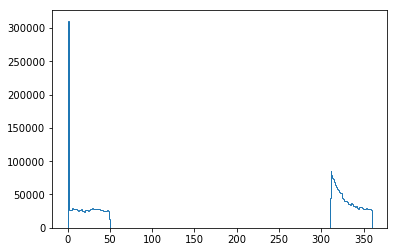

In [10]:
plt.hist(hlc["RA_MEAN_CLIP"], histtype="step", bins=360)
plt.xlabel("Ra")
plt.ylabel("Counts")

## Setup matched catalog paths

Cross-matching was done with astropy on Epyc where the matching criterion is "1^st neighbour". This ensures all objects in the catalog have a match. The cross-matched objects are stored in `domain2codomain_cat` catalog files where the `domain` indicates the catalog that was used to cross-match objects and `codomain` the catalog on which the cross-matching was performed. This way accessing the `domain2codomain_cat` catalog provides access to `codomain` objects that were matched to `domain` objects. I.e. `hlc2nsc_cat` is a catalog of all objects from NSC that were matched to HLC.    

To get unique and real cross-matches the data has to be masked. The `xmatch_domain2codomain` files contain the original matched index, angular separation between the two matched objects in arcseconds and the 3D distance between the objects.

Again, due to RAM requirements not all catalogs are read in and only certain columns are kept from the ones that are.

In [4]:
DATA_DIR = "data/matched1/"
HLC2NSC_FILES = DATA_DIR+"hlc2nsc_cat"
GAI2NSC_FILES = DATA_DIR+"gaia2nsc_cat"
GAI2HLC_FILES = DATA_DIR+"gaia2hlc_cat"

HLC2NSC_XMATCH = DATA_DIR+"xmatch_hlc2nsc"
GAI2NSC_XMATCH = DATA_DIR+"xmatch_gaia2nsc"
GAI2HLC_XMATCH = DATA_DIR+"xmatch_gaia2hlc"

print("\nRegistered following HLC2NSC files: ")
print("    "+HLC2NSC_FILES)
print("    "+HLC2NSC_XMATCH)
print("\nRegistered following GAI2NSC files: ")
print("    "+GAI2NSC_FILES)
print("    "+GAI2NSC_XMATCH)
print("\nRegistered following GAI2HLC files: ")
print("    "+GAI2HLC_FILES)
print("    "+GAI2HLC_XMATCH)


Registered following HLC2NSC files: 
    data/matched1/hlc2nsc_cat
    data/matched1/xmatch_hlc2nsc

Registered following GAI2NSC files: 
    data/matched1/gaia2nsc_cat
    data/matched1/xmatch_gaia2nsc

Registered following GAI2HLC files: 
    data/matched1/gaia2hlc_cat
    data/matched1/xmatch_gaia2hlc


In [5]:
def get_xmatch_info(path):
    xmatchdat = []
    with open(path, "r") as xmatch:
        for line in xmatch.readlines():
            xmatchdat.append(np.fromstring(line, sep=" ",dtype=np.float64))
    idx, angsep, dist = xmatchdat[0], xmatchdat[1], xmatchdat[2]
    return idx, angsep, dist

In [6]:
hlc2nsc = Table.read(HLC2NSC_FILES, format="ascii")
ra2 = hlc2nsc["ra"]
dec2 = hlc2nsc["dec"]
t2 = hlc2nsc["mjd"]
pmra2 = hlc2nsc["pmra"]
pmdec2 = hlc2nsc["pmdec"]
objtype2 = hlc2nsc["class_star"]
del hlc2nsc
# can not afford to read all of them in due to RAM requirements
#gai2nsc = Table.read(GAI2NSC_FILES, format="ascii")
#gai2hlc = Table.read(GAI2HLC_FILES, format="ascii")

In [7]:
hlc2nsc_id, hlc2nsc_angsep, hlc2nsc_dist = get_xmatch_info(HLC2NSC_XMATCH)
# can not afford to read all of them in due to RAM requirements
#gai2nsc_id, gai2nsc_angsep, gai2nsc_dist = get_xmatch_info(GAI2NSC_XMATCH)
#gai2hlc_id, gai2hlc_angsep, gai2hlc_dist = get_xmatch_info(GAI2HLC_XMATCH)

## Make sure separations and matches look ok

Check the number of matches.    
Check which RA match most often.    
Check what is the separation distribution of valid matches.

In [13]:
print(len(hlc2nsc_angsep[hlc2nsc_angsep<1]))
print(len(gai2nsc_angsep[gai2nsc_angsep<1]))
print(len(gai2hlc_angsep[gai2hlc_angsep<1]))

2583362
535837
611150


In [14]:
print(len(hlc2nsc_angsep))
print(len(gai2nsc_angsep))
print(len(gai2hlc_angsep))

3418266
715436
715436


### First for HLC2NSC matches

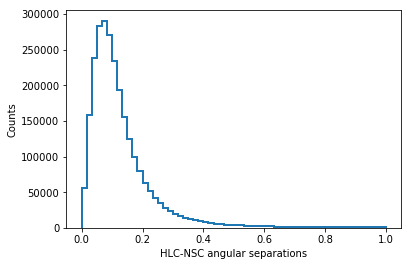

In [37]:
plt.hist(hlc2nsc_angsep[hlc2nsc_angsep<1], histtype='step', lw=2 , bins=60)
plt.xlabel("HLC-NSC angular separations")
plt.ylabel("Counts")

### Then Gaia2NSC matches

The original 1st neighbour matching pairs a lot of objects to Ra=50 degrees. These are not confident matches because the angular separations between the matched objects are larger than 1 arcsecond.    
Additionally, these are not only unique (1-to-1 correspondence) matches. However, the number of objects from codomain that were matched to the same domain object is very low (~640). This is not enough to affect the statistic significantly.

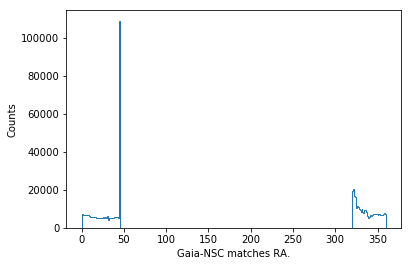

In [40]:
a = plt.hist(gai2nsc["ra"], histtype="step", bins=360)
plt.xlabel("Gaia-NSC matches RA.")
plt.ylabel("Counts")

But if we plot only the matches under 1 arcsecond we get

640

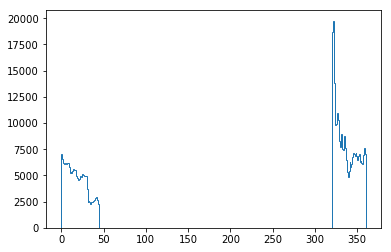

In [57]:
mask = gai2nsc_angsep<1
plt.hist(gai2nsc[mask]["ra"], histtype="step", bins=360)
len(gai2nsc[mask]) - len(np.unique(gai2nsc[mask]))

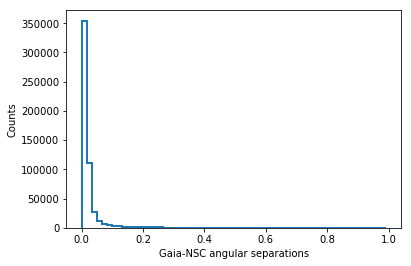

In [42]:
a = plt.hist(gai2nsc_angsep[gai2nsc_angsep<1], histtype='step', lw=2 , bins=60)
plt.xlabel("Gaia-NSC angular separations")
plt.ylabel("Counts")

### Finally for Gaia to HLC matches

The original 1st neighbour matching pairs a lot of objects to Ra=50 degrees. These are not confident matches because the angular separations between the matched objects are larger than 1 arcsecond.

There are ~800 multiply matched objects. 

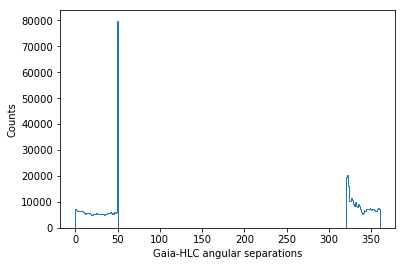

In [44]:
a = plt.hist(gai2hlc["RA_MEAN_CLIP"], histtype="step", bins=360)
plt.xlabel("Gaia-HLC angular separations")
plt.ylabel("Counts")

and again, once we plot only the matches that are under 1 arcsecond we get

668

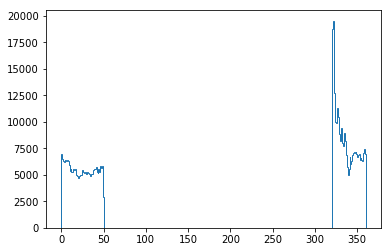

In [59]:
mask = gai2hlc_angsep<1
plt.hist(gai2hlc[mask]["RA_MEAN_CLIP"], histtype="step", bins=360)
len(gai2hlc[mask]) - len(np.unique(gai2hlc[mask]))

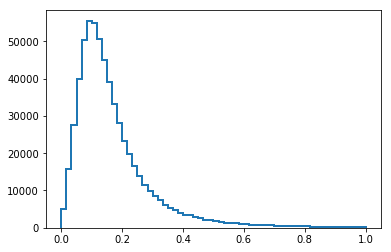

In [31]:
a = plt.hist(gai2hlc_angsep[gai2hlc_angsep<1], histtype='step', lw=2 , bins=60)

## Plot the differences between crossmatched HLC and NSC RA and DEC coordinates 

In [8]:
dra = 3600.*(ra - ra2)
ddec = 3600.*(dec - dec2)
print(len(dra), len(ddec))

mask = hlc2nsc_angsep < 1
dram = 3600.*(ra[mask]- ra2[mask])
ddecm = 3600.*(dec[mask]- dec2[mask])
print(len(dram), len(ddecm))

3418266 3418266
2583362 2583362


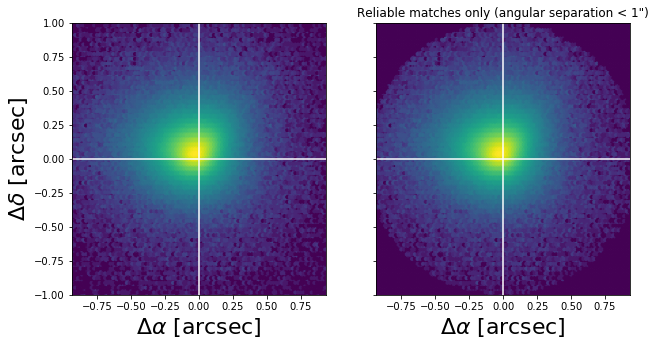

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].hexbin(dra, ddec, bins='log', extent=(-1, 1, -1, 1))
ax[1].hexbin(dram, ddecm, bins='log', extent=(-1, 1, -1, 1))

ax[0].set_ylabel(r"$\Delta\delta$ [arcsec]", fontsize=22)
ax[1].set_title("Reliable matches only (angular separation < 1\")")
for a in ax:
    #add cross
    a.axhline(0, c="white")
    a.axvline(0, c="white")
    
    #prettify
    a.axis('equal')
    a.set_xlabel(r"$\Delta\alpha$ [arcsec]", fontsize=22)
    a.set_xlim([-1, 1])
    a.set_ylim([-1, 1])

## Correcting the positional matches by using proper motions from HLC and NSC

1. All objects whose angular separation is larger than 1 arcsecond are masked out
1. All objects that are not catalogued as stars are masked out
1. All objects that have unrealistic proper motion values are masked out
1. All values are scaled to the same units (mas, mas/year, MJD)
1. Positional differences of original data are computed in mas
1. The time differences between observations are computed in years
1. Time differences are multiplied either by proper motion from HLC catalog or by proper motion from NSC catalog to calculate the supposed motion of the star.
1. The calculated motion is added to the original data for HLC and NSC proper motions respectively

HLC proper motions seem to correct the cross-matched positional discrepancies much better than NSC proper motion values. 

In [83]:
deg2mas =  3600 * 1000.

# what is going on with some of these values
angsep_mask = hlc2nsc_angsep < 1
objtype_mask = objtype2 > 0.5
pmra1_mask = (pmra<1) & (pmra>-1)
pmdec1_mask = (pmdec<1) & (pmdec>-1)
pmra2_mask = (pmra2<1) & (pmra2>-1)
pmdec2_mask = (pmdec2<1) & (pmdec2>-1)
mask = angsep_mask * objtype_mask * pmra1_mask * pmdec1_mask

# scaling HLC values 
ra1_mas = ra[mask]*deg2mas
dec1_mas = dec[mask]*deg2mas 
pmra1_mas = pmra[mask]*1000.
pmdec1_mas = pmdec[mask]*1000.
hlc_t = t0[mask]
hlct =  apy.time.Time(hlc_t, format='jd')

# scaling NSC values
ra2_mas = ra2[mask]*deg2mas
dec2_mas = dec2[mask]*deg2mas 
pmra2_mas = pmra2[mask]
pmdec2_mas = pmdec2[mask]
nsc_t = t2[mask]
nsct =  apy.time.Time(nsc_t, format='mjd')

# get the positional difference between HLC and xmatched NSC object, this is dram and ddecm esentially
dra_mas = ra1_mas - ra2_mas
ddec_mas = dec1_mas - dec2_mas

# get the time difference between HLC object observation and xmatched NSC obsevation
dt = nsct - hlct
dt_years = (nsct.mjd - hlct.mjd) / 365.

# calculate the motion of the star via HLC proper motion values
dracorr1 = pmra1_mas * dt_years
ddeccorr1 = pmdec1_mas * dt_years

# calculate the motion of the star via NSC proper motion values
dracorr2 = pmra2_mas * dt_years
ddeccorr2 = pmdec2_mas * dt_years

# correct catalog positions by using HLC proper motion
dra_mas_hlc = dra_mas + dracorr1
ddec_mas_hlc = ddec_mas + ddeccorr1

# correct catalog positions by using NSC proper motion
dra_mas_nsc = dra_mas + dracorr2
ddec_mas_nsc = ddec_mas + ddeccorr2

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


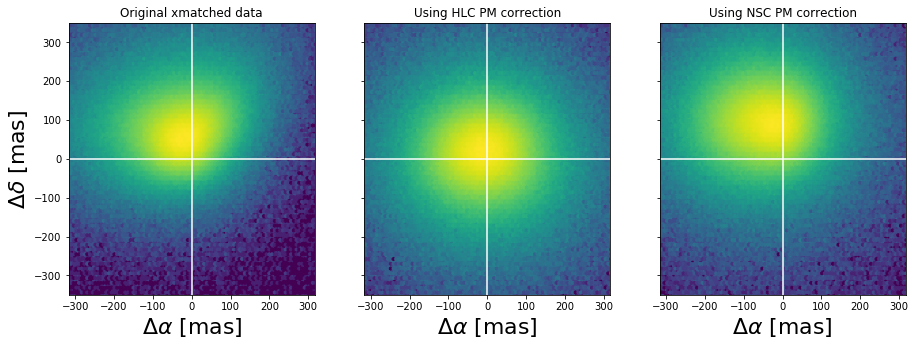

In [82]:
xlim = [-350, 350]
ylim = xlim

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax[0].hexbin(dra_mas, ddec_mas, bins='log', extent=[*xlim, *ylim])
ax[1].hexbin(dra_mas_hlc, ddec_mas_hlc, bins='log', extent=[*xlim, *ylim])
ax[2].hexbin(dra_mas_nsc, ddec_mas_nsc, bins='log', extent=[*xlim, *ylim])

ax[0].set_ylabel(r"$\Delta\delta$ [mas]", fontsize=22)
ax[0].set_title("Original xmatched data")
ax[1].set_title("Using HLC PM correction")
ax[2].set_title("Using NSC PM correction")
for a in ax:
    a.axis("equal")
    a.set_xlabel(r"$\Delta\alpha$ [mas]", fontsize=22)
    
    a.axhline(0, c="white")
    a.axvline(0, c="white")
    
    a.set_xlim(xlim)
    a.set_ylim(ylim)